<a href="https://colab.research.google.com/github/jkcg-learning/FaceMask_ImageClassification/blob/master/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dphi

##Data Sprint #6: Face Mask Detection

https://dphi.tech/practice/challenge/34#problem

* Submitted by : - Jyothish Kumar C G




Importing the necessary libraries

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
%load_ext tensorboard

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

print(tf.__version__)

2.4.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Downloading the dataset

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo',
                                    dest_path='/content/FaceMaskDetection.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
#importing necessary libraries
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
class_names = ['without_mask','with_mask']
IMG_SIZE = 256

In [5]:
import pandas as pd
train_data = pd.read_csv('./face_mask_detection/Training_set_face_mask.csv')
train_data

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask
...,...,...
11259,Image_11260.jpg,with_mask
11260,Image_11261.jpg,with_mask
11261,Image_11262.jpg,with_mask
11262,Image_11263.jpg,with_mask


In [6]:
file_paths = [[fname, './face_mask_detection/train/' + fname] for fname in train_data['filename']]
file_paths[0:5]

[['Image_1.jpg', './face_mask_detection/train/Image_1.jpg'],
 ['Image_2.jpg', './face_mask_detection/train/Image_2.jpg'],
 ['Image_3.jpg', './face_mask_detection/train/Image_3.jpg'],
 ['Image_4.jpg', './face_mask_detection/train/Image_4.jpg'],
 ['Image_5.jpg', './face_mask_detection/train/Image_5.jpg']]

In [7]:
# Confirm if number of images is same as number of labels given
if len(train_data) == len(file_paths):
    print('Number of labels i.e. ', len(train_data), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  11264 matches the number of filenames i.e.  11264


Mapping images with image path 

In [8]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,./face_mask_detection/train/Image_1.jpg
1,Image_2.jpg,./face_mask_detection/train/Image_2.jpg
2,Image_3.jpg,./face_mask_detection/train/Image_3.jpg
3,Image_4.jpg,./face_mask_detection/train/Image_4.jpg
4,Image_5.jpg,./face_mask_detection/train/Image_5.jpg


In [9]:
train_data_modified = pd.merge(images, train_data, how = 'inner', on = 'filename')
train_data_modified.head() 

,filename,filepaths,label
0,Image_1.jpg,./face_mask_detection/train/Image_1.jpg,without_mask
1,Image_2.jpg,./face_mask_detection/train/Image_2.jpg,without_mask
2,Image_3.jpg,./face_mask_detection/train/Image_3.jpg,without_mask
3,Image_4.jpg,./face_mask_detection/train/Image_4.jpg,without_mask
4,Image_5.jpg,./face_mask_detection/train/Image_5.jpg,without_mask


In [10]:
train_data_modified.tail() 

,filename,filepaths,label
11259,Image_11260.jpg,./face_mask_detection/train/Image_11260.jpg,with_mask
11260,Image_11261.jpg,./face_mask_detection/train/Image_11261.jpg,with_mask
11261,Image_11262.jpg,./face_mask_detection/train/Image_11262.jpg,with_mask
11262,Image_11263.jpg,./face_mask_detection/train/Image_11263.jpg,with_mask
11263,Image_11264.jpg,./face_mask_detection/train/Image_11264.jpg,with_mask


In [11]:
train_data_without_mask = train_data_modified[train_data_modified['label'] == 'without_mask']
train_data_without_mask

,filename,filepaths,label
0,Image_1.jpg,./face_mask_detection/train/Image_1.jpg,without_mask
1,Image_2.jpg,./face_mask_detection/train/Image_2.jpg,without_mask
2,Image_3.jpg,./face_mask_detection/train/Image_3.jpg,without_mask
3,Image_4.jpg,./face_mask_detection/train/Image_4.jpg,without_mask
4,Image_5.jpg,./face_mask_detection/train/Image_5.jpg,without_mask
...,...,...,...
5627,Image_5628.jpg,./face_mask_detection/train/Image_5628.jpg,without_mask
5628,Image_5629.jpg,./face_mask_detection/train/Image_5629.jpg,without_mask
5629,Image_5630.jpg,./face_mask_detection/train/Image_5630.jpg,without_mask
5630,Image_5631.jpg,./face_mask_detection/train/Image_5631.jpg,without_mask


In [12]:
train_data_mask = train_data_modified[train_data_modified['label'] == 'with_mask']
train_data_mask

,filename,filepaths,label
5632,Image_5633.jpg,./face_mask_detection/train/Image_5633.jpg,with_mask
5633,Image_5634.jpg,./face_mask_detection/train/Image_5634.jpg,with_mask
5634,Image_5635.jpg,./face_mask_detection/train/Image_5635.jpg,with_mask
5635,Image_5636.jpg,./face_mask_detection/train/Image_5636.jpg,with_mask
5636,Image_5637.jpg,./face_mask_detection/train/Image_5637.jpg,with_mask
...,...,...,...
11259,Image_11260.jpg,./face_mask_detection/train/Image_11260.jpg,with_mask
11260,Image_11261.jpg,./face_mask_detection/train/Image_11261.jpg,with_mask
11261,Image_11262.jpg,./face_mask_detection/train/Image_11262.jpg,with_mask
11262,Image_11263.jpg,./face_mask_detection/train/Image_11263.jpg,with_mask


Creating two new folders **0_without_mask** and **1_with_mask** and moving the corresponding images into these folders

In [13]:
import os
def move_file(old_file_path, new_directory):
    if not os.path.isdir(new_directory):
        os.mkdir(new_directory)
    base_name = os.path.basename(old_file_path)
    new_file_path = os.path.join(new_directory, base_name)
    # Deletes a file if that file already exists there, you can change this behavior
    if os.path.exists(new_file_path):
        os.remove(new_file_path)
    os.rename(old_file_path, new_file_path)


In [14]:
destination_folder_without_mask = './face_mask_detection/train/0_without_mask'
destination_folder_with_mask = './face_mask_detection/train/1_with_mask'

for file_without_mask in train_data_without_mask['filepaths']:
  move_file(file_without_mask, destination_folder_without_mask) 


for file_mask in train_data_mask['filepaths']:
  move_file(file_mask, destination_folder_with_mask)

we can use flow_from_directory function if the images are properly classified into the folders (in our case 0_without_mask and 1_with_mask)

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 20,  # for augmentation
                                   shear_range = 20,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   vertical_flip=True,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

val_datagen = ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

train_generator = train_datagen.flow_from_directory("./face_mask_detection/train/",
                                                    batch_size = 32,
                                                    subset="training",
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode = 'binary', 
                                                    target_size = (IMG_SIZE,IMG_SIZE))

val_generator = val_datagen.flow_from_directory("./face_mask_detection/train/",
                                                    batch_size = 32,
                                                    seed=42,
                                                    shuffle=True,
                                                    subset = "validation",
                                                    class_mode = 'binary', 
                                                    target_size = (IMG_SIZE,IMG_SIZE))


Found 9012 images belonging to 2 classes.
Found 2252 images belonging to 2 classes.


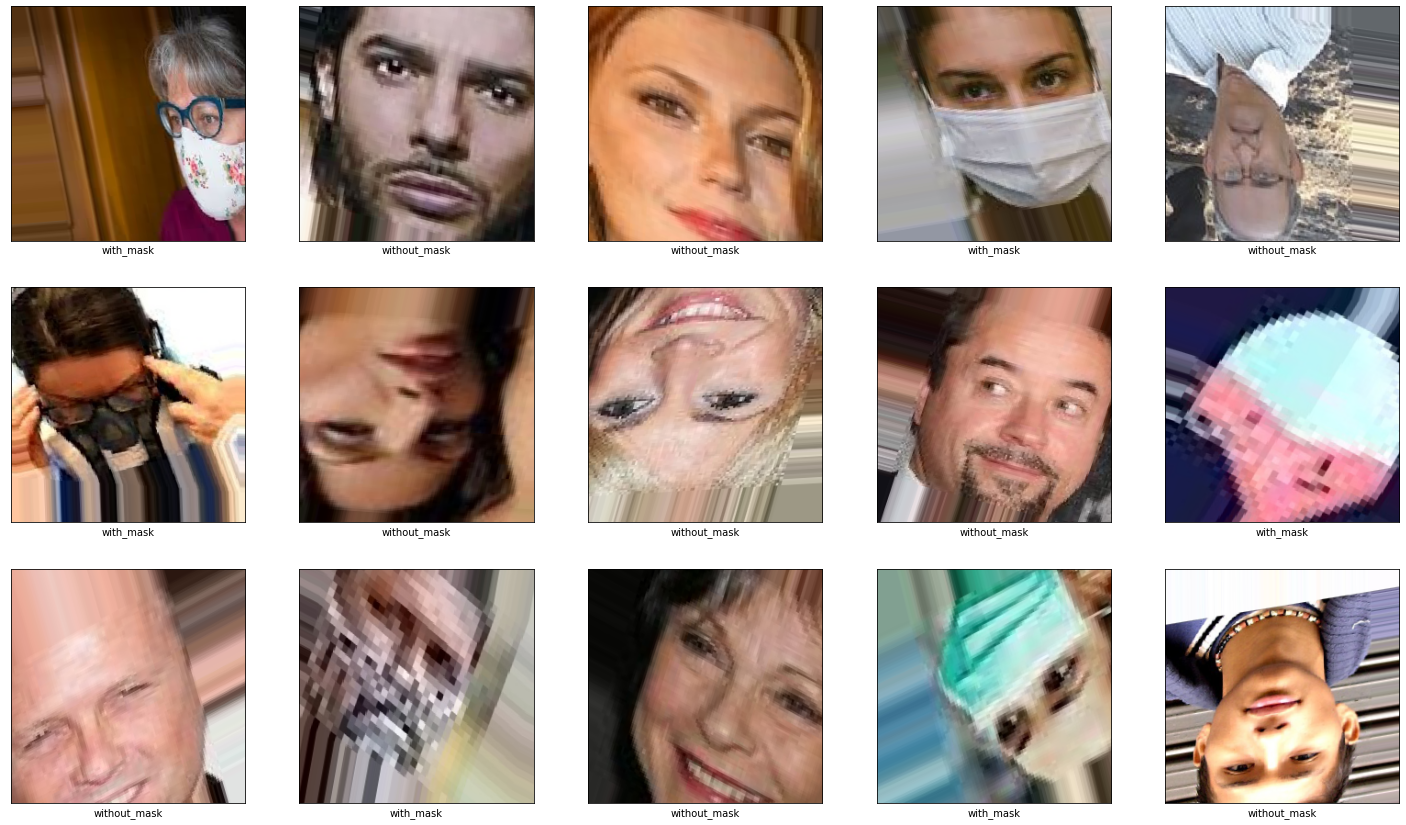

In [16]:
from keras.preprocessing import image as imageDisplay

x,y = train_generator.next()
plt.figure(figsize=(25,25))

for i in range(15):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  imageDisplay = x[i]
  label = y[i]
  plt.imshow(imageDisplay)     
  plt.imshow(imageDisplay)
  if(label == 0.0):
    plt.xlabel(class_names[0])
  elif(label == 1.0):
    plt.xlabel(class_names[1])


In [17]:
lrr= ReduceLROnPlateau(
                       monitor='val_loss', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_loss, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [18]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [19]:
# plotting helper function
def plotaccuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [20]:
# plotting helper function
def plotloss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Transfer learning:  Model used **Resnet50**

In [21]:
# define input shape
INPUT_SHAPE_RESNET = (IMG_SIZE, IMG_SIZE, 3)

# get the Resnet model
ResNet_layers = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE_RESNET)

ResNet_layers.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [22]:
# Fine-tune all the layers
for layer in ResNet_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in ResNet_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3add269470> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f3add4dc780> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3adf8891d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3add27a6d8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3add1f4f28> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f3add1a7668> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3add1a7198> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3add1b3390> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3add1bafd0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3add1c9358> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3add1c9cf8> True
<tensorflow.python.keras.layers.normaliz

In [23]:
# define sequential model
model_ResNet = Sequential()

# Add the efficientNet convolutional base model
model_ResNet.add(ResNet_layers)

# add flatten layer
model_ResNet.add(Flatten())


#model_ResNet.add(Dense(512, activation='relu'))
#model_ResNet.add(Dropout(0.3))
model_ResNet.add(Dense(512, activation='relu'))
#model_ResNet.add(Dropout(0.2))

model_ResNet.add(Dense(1, activation='sigmoid'))


# compile model
model_ResNet.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
model_ResNet.summary()

# view model layers
model_ResNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 90,697,601
Trainable params: 90,644,481
Non-trainable params: 53,120
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
___________________

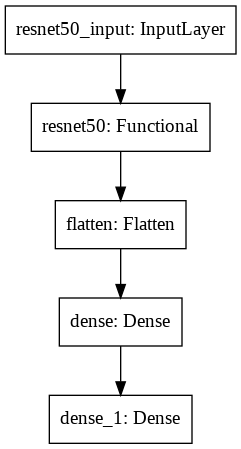

In [24]:
keras.utils.plot_model(model_ResNet)

In [25]:
model_checkpoint_RESNET = keras.callbacks.ModelCheckpoint(
    './best_weights_resent.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="min",
    min_delta=0.001,
)

In [26]:
EPOCHS = 5
BATCH_SIZE = 32

history_RESNET = model_ResNet.fit(train_generator,
                    validation_data = val_generator,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=(len(train_data_modified)*0.8) // BATCH_SIZE,
                    validation_steps=(len(train_data_modified)*0.2) // BATCH_SIZE,
                    callbacks = [model_checkpoint_RESNET, es_callback, reduce_lr], 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/5
281/281 [==============================] - 207s 707ms/step - loss: 3.7705 - accuracy: 0.8078 - val_loss: 1.4505 - val_accuracy: 0.4996

Epoch 00001: val_loss improved from inf to 1.45050, saving model to ./best_weights_resent.h5
Epoch 2/5
281/281 [==============================] - 195s 696ms/step - loss: 0.0866 - accuracy: 0.9705 - val_loss: 1.7541 - val_accuracy: 0.4763

Epoch 00002: val_loss did not improve from 1.45050
Epoch 3/5
281/281 [==============================] - 193s 686ms/step - loss: 0.0724 - accuracy: 0.9749 - val_loss: 1.1034 - val_accuracy: 0.5696

Epoch 00003: val_loss improved from 1.45050 to 1.10340, saving model to ./best_weights_resent.h5
Epoch 4/5
281/281 [==============================] - 193s 684ms/step - loss: 0.0684 - accuracy: 0.9759 - val_loss: 0.0751 - val_accuracy: 0.9781

Epoch 00004: val_loss improved from 1.10340 to 0.07511, saving model to ./best_weights_resent.h5
Epoch 5/5
281/281 [==============================] - 191s 678ms/step - loss: 0

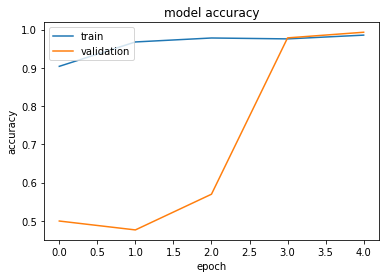

In [27]:
plotaccuracy(history_RESNET)

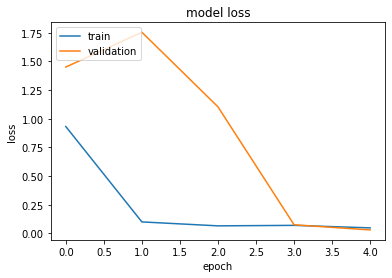

In [28]:
plotloss(history_RESNET)

Transfer learning: Model used **Xception**

In [29]:
# define input shape
INPUT_SHAPE_XCEPTION = (IMG_SIZE, IMG_SIZE, 3)

# get the Resnet model
Xception_layers = tf.keras.applications.Xception(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE_XCEPTION)

Xception_layers.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [30]:
# Fine-tune all the layers
for layer in Xception_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in Xception_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3ad238f898> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3ad2407710> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3add78c5f8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3ad2382978> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3ad3e5e7f0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3ad247bdd8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3ad23d4438> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f3b47f49d30> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3ad2382d68> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3ad23b29e8> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f3ad23a48d0> True
<tensorflow.python.keras.l

In [31]:
# define sequential model
model_Xception = Sequential()

# Add the efficientNet convolutional base model
model_Xception.add(Xception_layers)

# add flatten layer
model_Xception.add(Flatten())


model_Xception.add(Dense(512, activation='relu',kernel_regularizer = 'l2'))
model_Xception.add(Dropout(.4))
model_Xception.add(Dense(256,activation=('relu'),kernel_regularizer = 'l2'))
model_Xception.add(Dropout(.3))

# add output layer
model_Xception.add(Dense(1, activation='sigmoid'))

# compile model
model_Xception.compile(optimizer=sgd, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# view model layers
model_Xception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

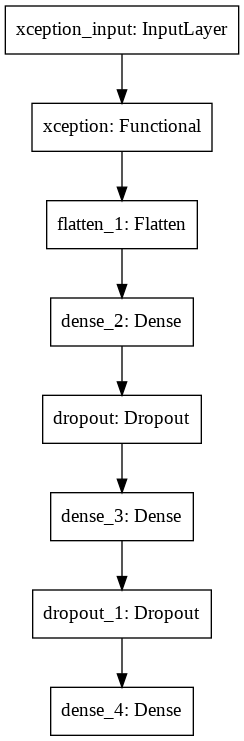

In [32]:
keras.utils.plot_model(model_Xception)

In [33]:
model_checkpoint_XCEPTION = keras.callbacks.ModelCheckpoint(
    './best_weights_xception.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [34]:
EPOCHS = 15
BATCH_SIZE = 32

history_XCEPTION = model_Xception.fit(train_generator,
                    validation_data = val_generator,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=(len(train_data_modified)*0.8) // BATCH_SIZE,
                    validation_steps=(len(train_data_modified)*0.2) // BATCH_SIZE,
                    callbacks = [model_checkpoint_XCEPTION, es_callback, reduce_lr], 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/15
281/281 [==============================] - 264s 918ms/step - loss: 13.5712 - accuracy: 0.8640 - val_loss: 12.2283 - val_accuracy: 0.9973

Epoch 00001: val_loss improved from inf to 12.22834, saving model to ./best_weights_xception.h5
Epoch 2/15
281/281 [==============================] - 256s 910ms/step - loss: 11.9374 - accuracy: 0.9828 - val_loss: 10.9288 - val_accuracy: 0.9982

Epoch 00002: val_loss improved from 12.22834 to 10.92877, saving model to ./best_weights_xception.h5
Epoch 3/15
281/281 [==============================] - 256s 908ms/step - loss: 10.6533 - accuracy: 0.9900 - val_loss: 9.7687 - val_accuracy: 0.9982

Epoch 00003: val_loss improved from 10.92877 to 9.76873, saving model to ./best_weights_xception.h5
Epoch 4/15
281/281 [==============================] - 256s 910ms/step - loss: 9.5226 - accuracy: 0.9889 - val_loss: 8.7292 - val_accuracy: 0.9987

Epoch 00004: val_loss improved from 9.76873 to 8.72921, saving model to ./best_weights_xception.h5
Epoch 5/15


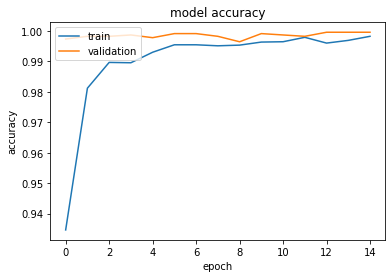

In [35]:
plotaccuracy(history_XCEPTION)

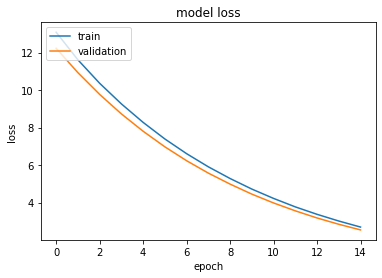

In [36]:
plotloss(history_XCEPTION)

In [37]:
test_data = pd.read_csv('./face_mask_detection/Testing_set_face_mask.csv')
test_data

,filename,label
0,Image_1.jpg,NaN
1,Image_2.jpg,NaN
2,Image_3.jpg,NaN
3,Image_4.jpg,NaN
4,Image_5.jpg,NaN
...,...,...
1531,Image_1532.jpg,NaN
1532,Image_1533.jpg,NaN
1533,Image_1534.jpg,NaN
1534,Image_1535.jpg,NaN


In [38]:
test_data['label'] = "./face_mask_detection/test/" + test_data['filename']
test_data


,filename,label
0,Image_1.jpg,./face_mask_detection/test/Image_1.jpg
1,Image_2.jpg,./face_mask_detection/test/Image_2.jpg
2,Image_3.jpg,./face_mask_detection/test/Image_3.jpg
3,Image_4.jpg,./face_mask_detection/test/Image_4.jpg
4,Image_5.jpg,./face_mask_detection/test/Image_5.jpg
...,...,...
1531,Image_1532.jpg,./face_mask_detection/test/Image_1532.jpg
1532,Image_1533.jpg,./face_mask_detection/test/Image_1533.jpg
1533,Image_1534.jpg,./face_mask_detection/test/Image_1534.jpg
1534,Image_1535.jpg,./face_mask_detection/test/Image_1535.jpg


In [39]:
data_test = []

try:
    files = test_data['label']
    for f in files:
      img = cv2.imread(f)
      img = cv2.resize(img,(IMG_SIZE,IMG_SIZE)) 
      data_test.append([np.array(img)])
except:
    pass   
    

In [40]:
type(data_test)


list

In [41]:
data_test_tf = tf.convert_to_tensor(data_test, np.float32)
print(type(data_test_tf))
data_test_tf[0]

<class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 53.,  63.,  81.],
         [ 51.,  61.,  79.],
         [ 45.,  55.,  73.],
         ...,
         [ 66., 107., 152.],
         [ 66., 107., 152.],
         [ 66., 107., 152.]],

        [[ 52.,  62.,  80.],
         [ 50.,  61.,  78.],
         [ 45.,  55.,  73.],
         ...,
         [ 66., 107., 152.],
         [ 66., 107., 152.],
         [ 66., 107., 152.]],

        [[ 51.,  61.,  78.],
         [ 49.,  59.,  77.],
         [ 43.,  53.,  72.],
         ...,
         [ 65., 106., 151.],
         [ 65., 106., 151.],
         [ 65., 106., 151.]],

        ...,

        [[135., 148., 192.],
         [134., 147., 191.],
         [133., 146., 190.],
         ...,
         [  4.,   2.,   6.],
         [  3.,   2.,   5.],
         [  3.,   2.,   5.]],

        [[136., 149., 193.],
         [136., 149., 193.],
         [135., 148., 192.],
         ...,
         [  4.,   2.,   6.],
         [  3.,   2.,   6.],
         

In [42]:
data_test_tf_reshaped = tf.reshape(data_test_tf,[1536 ,IMG_SIZE,IMG_SIZE,3])
data_test_tf_reshaped.shape

TensorShape([1536, 256, 256, 3])

In [43]:
data_test_normalized = np.divide(data_test_tf_reshaped, 255.0)
data_test_normalized[0]

array([[[0.20784314, 0.24705882, 0.31764707],
        [0.2       , 0.23921569, 0.30980393],
        [0.1764706 , 0.21568628, 0.28627452],
        ...,
        [0.25882354, 0.41960785, 0.59607846],
        [0.25882354, 0.41960785, 0.59607846],
        [0.25882354, 0.41960785, 0.59607846]],

       [[0.20392157, 0.24313726, 0.3137255 ],
        [0.19607843, 0.23921569, 0.30588236],
        [0.1764706 , 0.21568628, 0.28627452],
        ...,
        [0.25882354, 0.41960785, 0.59607846],
        [0.25882354, 0.41960785, 0.59607846],
        [0.25882354, 0.41960785, 0.59607846]],

       [[0.2       , 0.23921569, 0.30588236],
        [0.19215687, 0.23137255, 0.3019608 ],
        [0.16862746, 0.20784314, 0.28235295],
        ...,
        [0.25490198, 0.41568628, 0.5921569 ],
        [0.25490198, 0.41568628, 0.5921569 ],
        [0.25490198, 0.41568628, 0.5921569 ]],

       ...,

       [[0.5294118 , 0.5803922 , 0.7529412 ],
        [0.5254902 , 0.5764706 , 0.7490196 ],
        [0.52156866, 0

In [44]:
preds = model_Xception.predict(data_test_normalized)

In [45]:
preds

array([[2.0623251e-07],
       [9.9959558e-01],
       [8.9666346e-06],
       ...,
       [9.9999046e-01],
       [9.9992812e-01],
       [1.5084927e-07]], dtype=float32)

Threshold value is given 0.81 here...u may try different values and see whether accuracy is increasing slightly or not.

In [46]:
num_masks = []

for value in preds:
  if(value >= 0.81):
    num_masks.append(value)

len(num_masks)

766

In [47]:
prediction = []
for value in preds:
  if value < 0.81:
    prediction.append(0)      
  else:
    prediction.append(1)  

In [48]:
prediction[0:10]

[0, 1, 0, 0, 1, 1, 0, 1, 0, 0]

In [49]:
#Accessing classnames with predicted clases
final_predictions = [class_names[i] for i in prediction]
print(final_predictions[0:1536])

['without_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'without_m

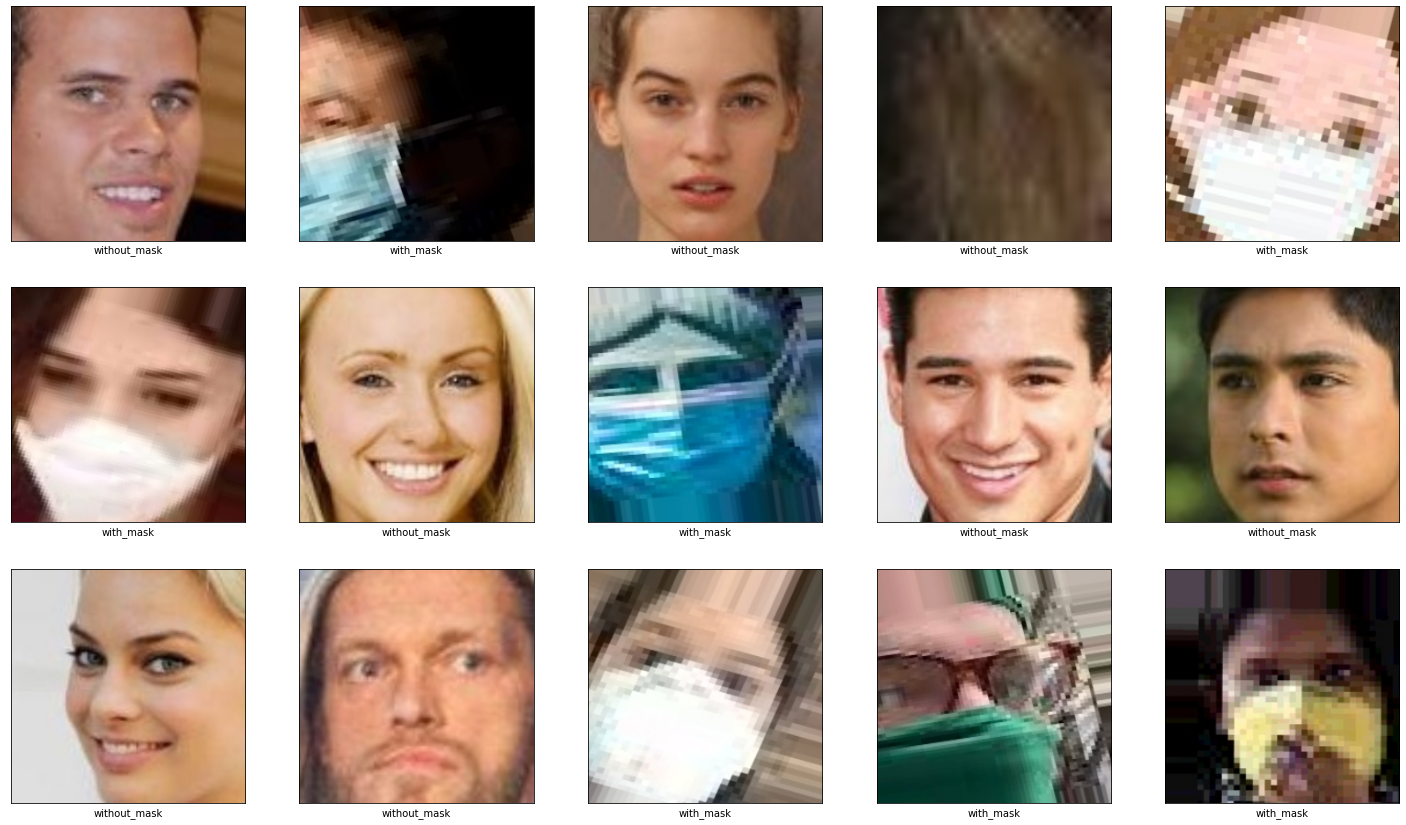

In [50]:
plt.figure(figsize=(25,25))

for i in range(15):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cv2.cvtColor(data_test_normalized[i], cv2.COLOR_BGR2RGB))  
  plt.xlabel(final_predictions[i])
  

plt.show()